# Code to check if cores are aligned

### Import modules

In [29]:
from PIL import Image
import glob
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
plt.rcParams['figure.figsize'] = [35,35]

### Get list of aligned images and masked images

In [6]:
# Get a list of all alignment images
fimgs = glob.glob('/common/lamt2/HPV/data/xenium/alignment_v2/aligned_cores/images/*_aligned.png')

# Get list of fold masks and background annotations
fmasks = [x.split('/')[-1].split('.')[0] for x in glob.glob('/common/lamt2/HPV/data/xenium/alignment_v2/annotations/images/output*foldmask.png')] + [x.split('/')[-1].split('.')[0] for x in glob.glob('/common/lamt2/HPV/data/xenium/alignment_v2/annotations/images/output*annot1.png')]

### This is used for realigning slides, since the python scripts take an index instead of the slide name

In [3]:
slide_idx = {
    'output-XETG00206__0060366__Region_1__20250305__223715': 0,
    'output-XETG00206__0060364__Region_1__20250305__223715': 1,
    'output-XETG00206__0060075__Region_1__20250213__202651': 2,
    'output-XETG00206__0060077__Region_1__20250213__202651': 3,
    'output-XETG00206__0060367__Region_1__20250224__233922': 4,
    'output-XETG00206__0060354__Region_1__20250224__233922': 5,
    'output-XETG00403__0060395__Region_1__20250304__005817': 6,
    'output-XETG00403__0059911__Region_1__20250304__005817': 7,
    'output-XETG00206__0060488__Region_1__20250312__004017': 8,
    'output-XETG00206__0060493__Region_1__20250312__004017': 9
}

### We make the dataframe here (or read it in if it already exists)

In [4]:
# Make the dataframe (or read existing one in)
df = pd.DataFrame(columns = ['slide', 'slide_idx', 'core', 'aligned', 'has_fold', 'has_fold_mask', 'note'])
#if os.path.exists(f'/common/lamt2/HPV/data/xenium/alignment_v2/alignment_validation.csv'):
#    df = pd.read_csv(f'/common/lamt2/HPV/data/xenium/alignment_v2/alignment_validation.csv', index_col = 0)

### This is the main slide:

 * It shows an image of the aligned dapi/he (or if there's a fold mask, the overlaid fold mask and actual cell scatter plot)

 * You will get sequential prompts to enter the alignment level, if there is a fold in the slide, and any additional comments

 * If the image does not load when the alignment prompt appears, type 'reload' and it should reload the image (it should take <10 seconds to load normally)

 * If you need to stop alignment, type 'quit' when the alignment prompt appears. You can start up at the same spot by rerunning this cell, as long as you have the dataframe loaded

 * This code with automatically skip cores you've checked already. To override this and look at every slide, change recheck = True

In [ ]:
# For bookkeeping, I check one slide at a time and keep track of which ones are done
# Checked: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fimgs_filtered = [x for x in fimgs if list(slide_idx.keys())[0] in x]

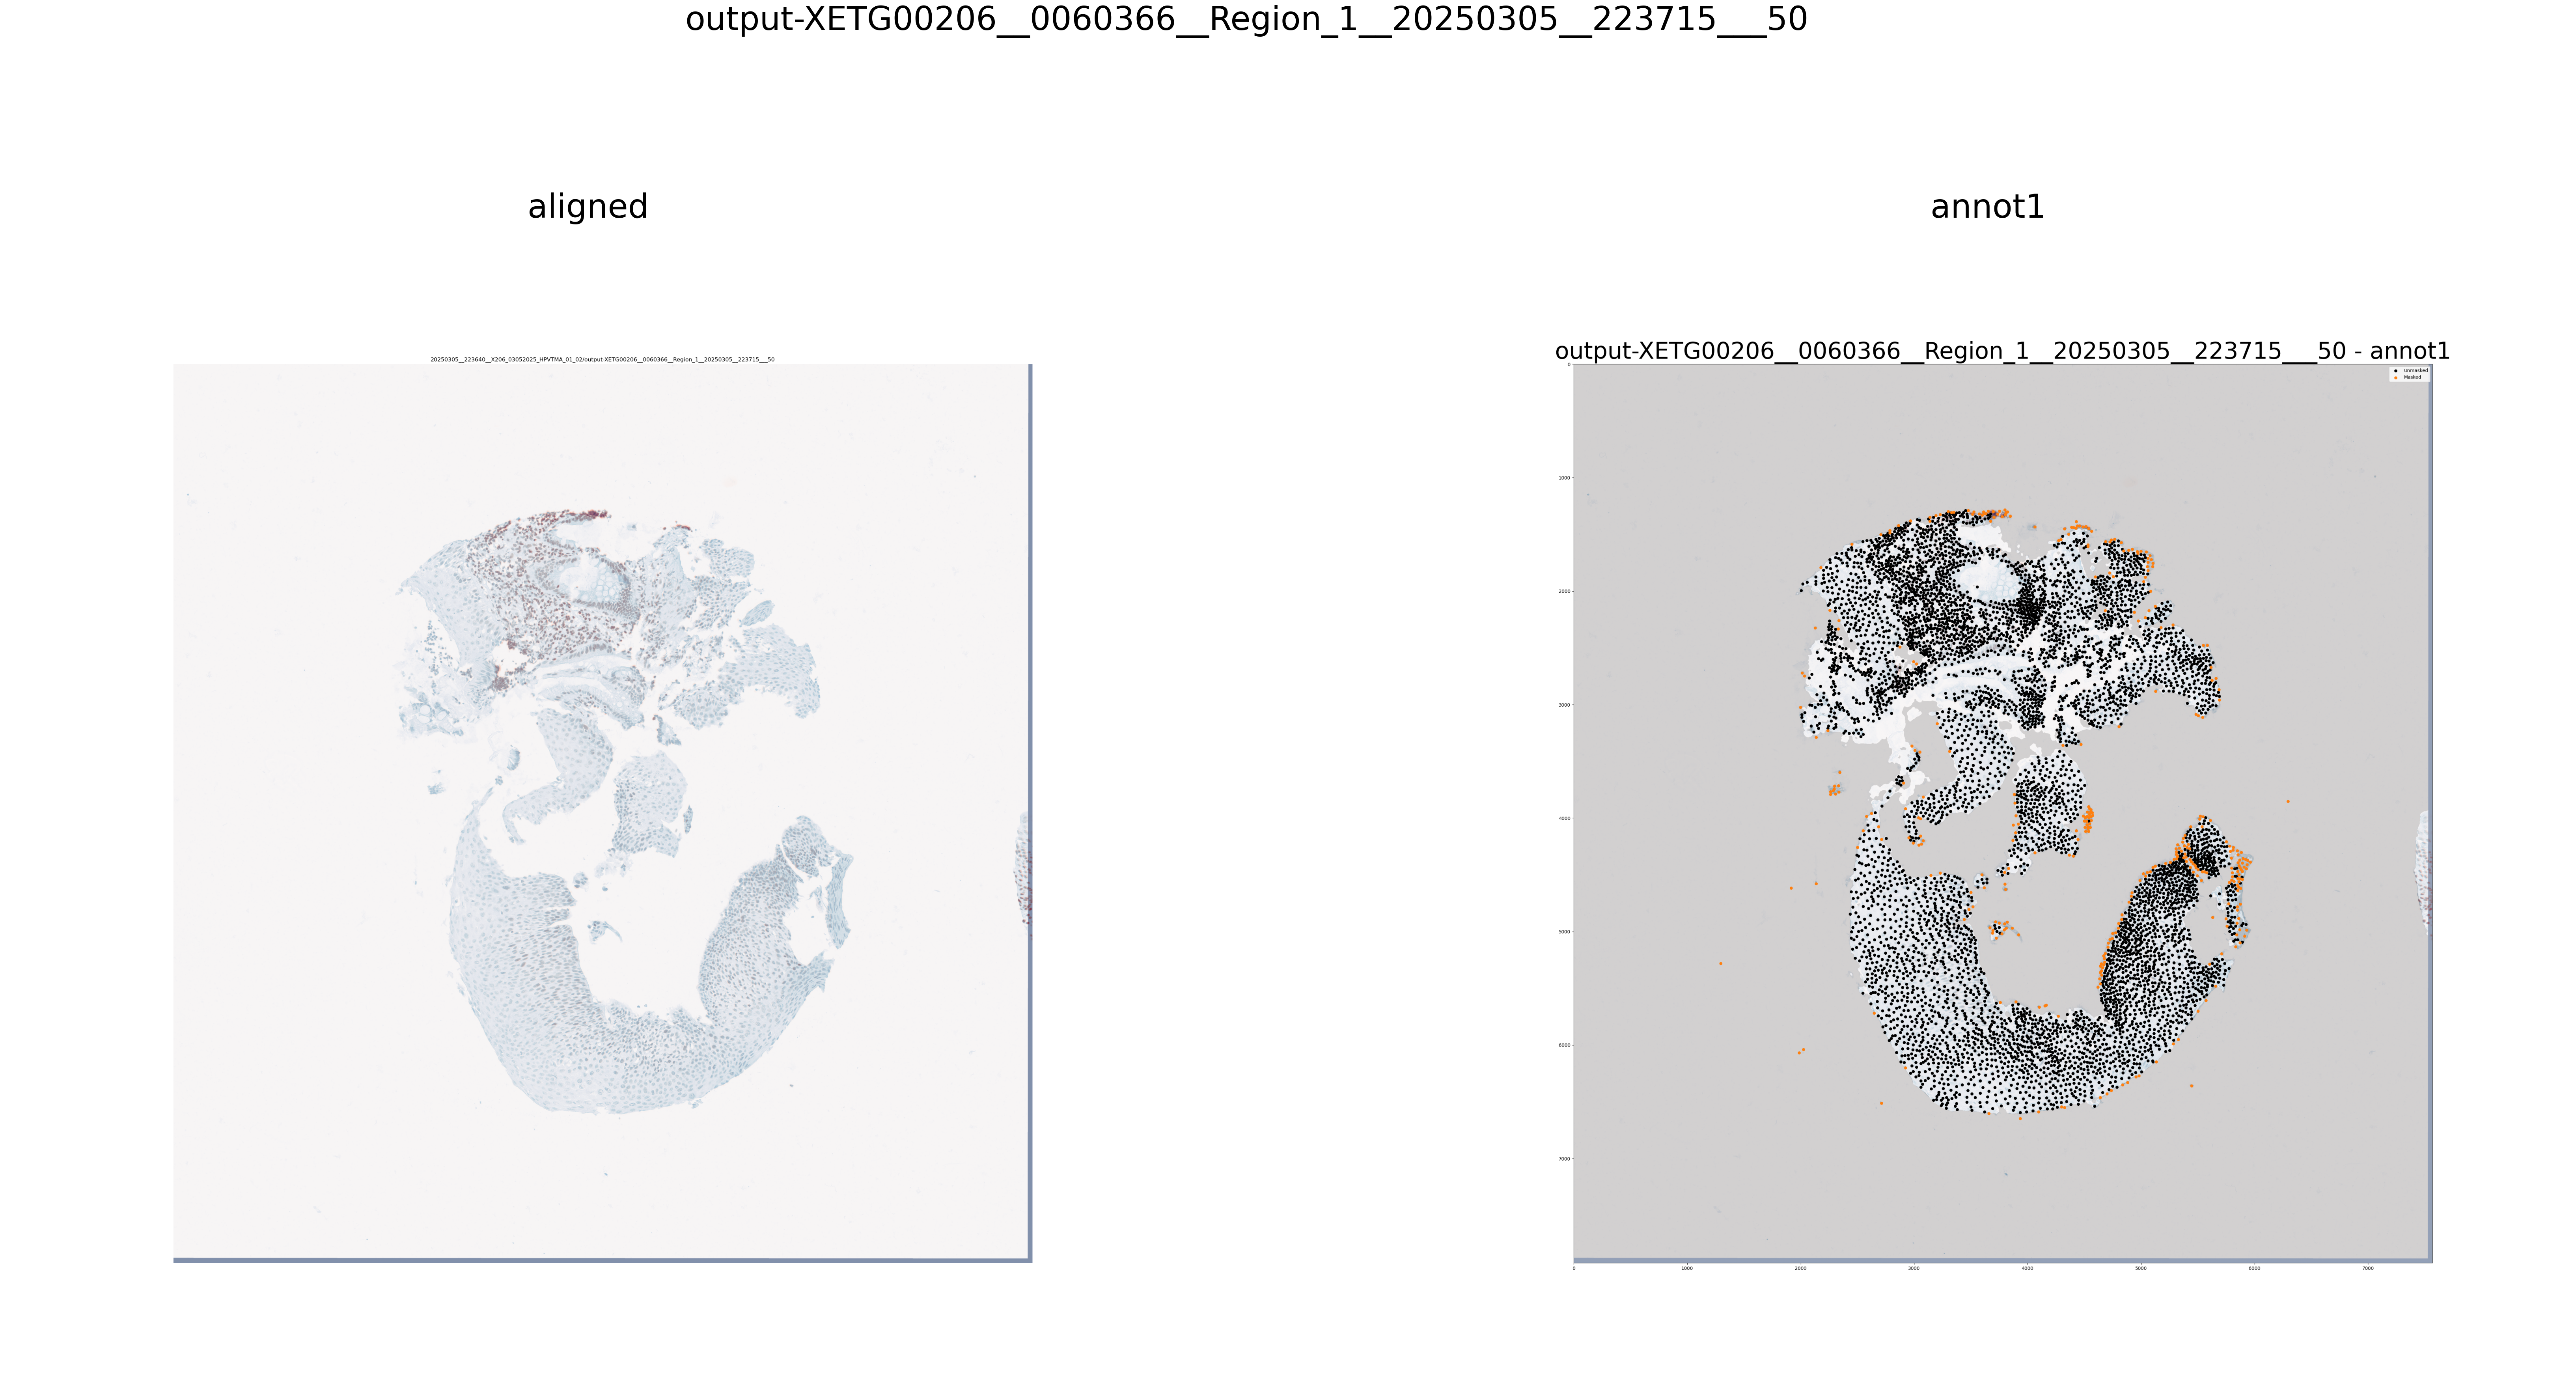

In [ ]:
# For the alignment level: these are my personal ratings but you can put any integer and change the scale to suit your needs
# 2 = well aligned, everything is good here
# 1 = aligned is good but but possible issues (parts moved during h&e staining, masks are incorrect, etc.)
# 0 = not well aligned/almost no well-aligned cells. Need to rerun alignment

recheck = False # Skip cores that have already been seen
for n,fimg in enumerate(fimgs_filtered):

    # Get the slide/core from the image name
    slide = fimg.split('/')[-1].split('___')[0]
    core = fimg.split('/')[-1].split('___')[1].split('_')[0]

    # If we've checked this slide already and are not rechecking, skip this image
    if f'{slide}___{core}' in df.index.values:
        if not recheck:
            continue
        row = df.loc[f'{slide}___{core}']
        #if row.aligned == 2:  #Condition if you only want to check certain slides
        #    continue
        print (row)
        
    has_fold_mask = False # Annotation mask has a non-zero value for fold masks somewhere
    
    # Display the image
    imgs = [f'/common/lamt2/HPV/data/xenium/alignment_v2/aligned_cores/images/{slide}___{core}_aligned.png']
    fmasks_filtered = list(filter(lambda x: x.startswith(f'{slide}___{core}_'), fmasks))
    for mask in fmasks_filtered:
        if 'foldmask' in mask:
            has_fold_mask = True
        imgs.append(f'/common/lamt2/HPV/data/xenium/alignment_v2/annotations/images/{mask}.png')
    if len(imgs) > 2:
        nrows = math.ceil(len(imgs) / 2)
        fig, ax = plt.subplots(nrows, 2, figsize = (35*2, 35*nrows), dpi = 120)
        for n, img in enumerate(imgs):
            row = n // 2
            col = n % 2
            ax[row][col].axis('off')
            ax[row][col].imshow(Image.open(img), aspect = 'equal')
            #ax[n].autoscale()
            ax[row][col].set_title(img.split('_')[-1].split('.')[0], fontsize = 50)
        for i in range(len(imgs), 2 * nrows):
            row = i // 2
            col = i % 2
            ax[row][col].remove()
    else:
        fig, ax = plt.subplots(1, 2, figsize = (35*2, 35), dpi = 120)
        for n, img in enumerate(imgs):
            ax[n].axis('off')
            ax[n].imshow(Image.open(img), aspect = 'equal')
            #ax[n].autoscale()
            ax[n].set_title(img.split('_')[-1].split('.')[0], fontsize = 50)
    fig.suptitle(f'{slide}___{core}', fontsize = 50)
    plt.show()

    # Get input for alignment level
    # Alignment degree outlined above
    # reload option: use if image fails to display in notebook
    # quit: use to exit the loop over cores
    aligned = input(f'Core {core} ({n+1}/{len(fimgs_filtered)}) alignment: 0/1/[2] or (r)eload/(q)uit/(s)kip') or 2
    while aligned == 'reload' or aligned == 'r':
        if len(imgs) > 2:
            nrows = math.ceil(len(imgs) / 2)
            fig, ax = plt.subplots(nrows, 2, figsize = (35*2, 35*nrows), dpi = 120)
            for n, img in enumerate(imgs):
                row = n // 2
                col = n % 2
                ax[row][col].axis('off')
                ax[row][col].imshow(Image.open(img), aspect = 'equal')
                #ax[n].autoscale()
                ax[row][col].set_title(img.split('_')[-1].split('.')[0], fontsize = 50)
            for i in range(len(imgs), 2 * nrows):
                row = i // 2
                col = i % 2
                ax[row][col].remove()
        else:
            fig, ax = plt.subplots(1, 2, figsize = (35*2, 35), dpi = 120)
            for n, img in enumerate(imgs):
                ax[n].axis('off')
                ax[n].imshow(Image.open(img), aspect = 'equal')
                #ax[n].autoscale()
                ax[n].set_title(img.split('_')[-1].split('.')[0], fontsize = 50)
        fig.suptitle(f'{slide}___{core}', fontsize = 50)
        plt.show()
        aligned = input(f'Core {core} ({n+1}/{len(fimgs_filtered)}) alignment: 0/1/[2] or (r)eload/(q)uit/(s)kip') or 2
        
    if aligned == 'quit' or aligned == 'q':
        break
    if aligned == 'skip' or aligned == 's':
        plt.close()
        clear_output(wait = False)
        continue
    
    has_fold = input(f'Core has fold (or possibly has fold): y/[n]') or 'n'
    input_dict = {'y': True, 'n': False}
    note = input(f'Note for core alignment:') or ''
    # Close the plots
    plt.close()
    clear_output(wait=False)
    
    # Add the image to the dataframe
    if f'{slide}___{core}' in df.index.values:
        df.loc[f'{slide}___{core}'] = {'slide': slide, 'slide_idx': slide_idx[slide], 'core': core, 'aligned': int(aligned), 'has_fold': input_dict[has_fold], 'has_fold_mask' : has_fold_mask, 'note': note}
    else:
        tmp = pd.DataFrame({'slide': slide, 'slide_idx': slide_idx[slide], 'core': core, 'aligned': int(aligned), 'has_fold': input_dict[has_fold], 'has_fold_mask' : has_fold_mask, 'note': note}, index = [f'{slide}___{core}'])
        df = pd.concat([df, tmp])
    if (n%10) == 0:
        df.to_csv(f'/common/lamt2/HPV/data/xenium/alignment_v2/alignment_validation.csv')

### If you've made a mistake in the alignment input, you can edit it using the examples below

In [ ]:
### Change the last alignment value to 1
#df.at[df.index[-1], 'align'] = 1

### Change the has_fold value for the 4th entry to True
#df.at[df.index[3], 'has_fold'] = True

In [7]:
# Write the dataframe to a csv
df.to_csv(f'/common/lamt2/HPV/data/xenium/alignment_v2/alignment_validation.csv')